<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/STEP200_Waypoint_FTDEMO_Mistral_7B_Instruct_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

In [ ]:
from datasets import load_from_disk
import colab_env

#Prepare the Dataset
dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")
#print(dataset)  # Inspect the dataset

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")


# Replace with your HF username and desired dataset name
dataset.push_to_hub("frankmorales2020/flight_plan_waypoints")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/frankmorales2020/flight_plan_waypoints/commit/875cf3439cd79ffd1d9c2f02e833104c565619d5', commit_message='Upload dataset', commit_description='', oid='875cf3439cd79ffd1d9c2f02e833104c565619d5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/frankmorales2020/flight_plan_waypoints', endpoint='https://huggingface.co', repo_type='dataset', repo_id='frankmorales2020/flight_plan_waypoints'), pr_revision=None, pr_num=None)

In [3]:
dataset

Dataset({
    features: ['input', 'label', 'distance', 'distance_category', 'waypoints', 'waypoint_names'],
    num_rows: 2000
})

In [4]:
dataset[999]

{'input': 'Calculate the waypoints from DEL to MSP. Departure: 2024-12-16, Aircraft: Boeing 757, Weather: Partly Cloudy',
 'label': 3,
 'distance': 1628.2675386906146,
 'distance_category': 'medium',
 'waypoints': [[38.6920451, -75.4013315],
  [41.13199069266402, -82.42994921256262],
  [42.51768770659504, -86.42165075117225],
  [42.123820505521195, -85.28705906429676],
  [44.878019050000006, -93.2209280537696]],
 'waypoint_names': ['DEL',
  'Prospect Road',
  'Michigan',
  'Q Drive South',
  'MSP']}

In [5]:
dataset[0]

{'input': 'Calculate the waypoints from SIN to CUN. Departure: 2024-06-19, Aircraft: Airbus A320, Weather: Partly Cloudy',
 'label': 7,
 'distance': 4190.223965150766,
 'distance_category': 'long',
 'waypoints': [[25.0000001, -107.5000001],
  [13.075850948259008, -87.47663616549106],
  [19.819922201759134, -98.80146877121005],
  [9.260386709076178, -81.06960216515675],
  [10.868386703521901, -83.76980061837503],
  [11.748790002704872, -85.24819840125659],
  [13.307169797892762, -87.86507323149776],
  [14.392416690114095, -89.68745009086217],
  [5.1096596, -74.0995854]],
 'waypoint_names': ['SIN',
  'Choluteca',
  'Santo Domingo Aztacameca',
  'Veraguas',
  'San Juan del Norte',
  'Acoyapa',
  'Pasaje La Cruz',
  'El Pito',
  'CUN']}

In [6]:
dataset[1999]

{'input': 'Calculate the waypoints from STL to BOG. Departure: 2024-09-06, Aircraft: Embraer E190, Weather: Clear',
 'label': 5,
 'distance': 4112.060597842354,
 'distance_category': 'long',
 'waypoints': [[38.74962725, -90.37047024952082],
  [21.18191627323041, -81.99991635501314],
  [10.923737947491404, -77.11216321240887],
  [15.739696160125035, -79.40684109194896],
  [25.474859626225587, -84.0453913602561],
  [13.045747925098976, -78.12324535656158],
  [4.7020946, -74.14771320401294]],
 'waypoint_names': ['STL',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'BOG']}

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

from datasets import load_from_disk
from datasets import Dataset
import torch
import colab_env


dataset = Dataset.load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
import bitsandbytes as bnb
import evaluate
from peft import LoraConfig, get_peft_model
import warnings
warnings.filterwarnings("ignore")

# Model and Tokenizer
#model_name = "mistralai/Mistral-7B-v0.1"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# PEFT Configuration (LoRA)
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Tokenize and Format
def tokenize_function(examples):
    # Directly use waypoint numbers as labels
    examples["labels"] = examples["label"]
    tokenized_output = tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Instead of assigning labels directly, shift them for causal LM
    tokenized_output['labels'] = tokenized_output['input_ids'].copy()
    # Replace input_ids corresponding to pad_token with -100 in labels
    tokenized_output['labels'] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label_list]
        for label_list in tokenized_output['labels']
    ]
    return tokenized_output

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print('\n')
print(tokenized_datasets)
print('\n')

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["input", "label"])
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split Dataset
train_testvalid = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
testvalid_dataset = train_testvalid["test"]
test_valid = testvalid_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = test_valid["test"]
test_dataset = test_valid["train"]

small_train_dataset = train_dataset.shuffle(seed=42).select(range(1600))
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(200))

# Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits[:, :-1, :].argmax(-1)
    labels_cleaned = labels[:, 1:]
    labels_cleaned = labels_cleaned[labels_cleaned != -100]
    predictions_cleaned = predictions.flatten()[labels[:, 1:].flatten() != -100]
    return metric.compute(predictions=predictions_cleaned, references=labels_cleaned)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to='none',
    logging_steps=10,
    push_to_hub=True,  # Set to True to enable pushing
    hub_model_id="frankmorales2020/flight_plan_waypoints_finetuned",  # Your desired model name on HF
)

In [3]:
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


In [4]:
train_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})

In [5]:
eval_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [6]:
small_train_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})

In [7]:
small_eval_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [8]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
10,2.447600,2.067366,0.550956
20,1.806900,1.519485,0.645669
30,1.295900,1.089006,0.724072
40,0.983700,0.879502,0.780877
50,0.852700,0.800670,0.808661
60,0.785700,0.757715,0.809786
70,0.745000,0.742282,0.815298
80,0.728100,0.732657,0.813386
90,0.724700,0.726242,0.813611
100,0.720600,0.722609,0.813611


TrainOutput(global_step=200, training_loss=0.9069195008277893, metrics={'train_runtime': 1718.2908, 'train_samples_per_second': 0.931, 'train_steps_per_second': 0.116, 'total_flos': 8741766719078400.0, 'train_loss': 0.9069195008277893, 'epoch': 1.0})

In [10]:
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
training_loss = [2.447600, 1.806900, 1.295900, 0.983700, 0.852700, 0.785700, 0.745000, 0.728100, 0.724700, 0.720600, 0.714100, 0.720800, 0.703000, 0.710300, 0.698500, 0.702700, 0.695600, 0.703200, 0.705500, 0.693800]
validation_loss = [2.067366, 1.519485, 1.089006, 0.879502, 0.800670, 0.757715, 0.742282, 0.732657, 0.726242, 0.722609, 0.720890, 0.715687, 0.713626, 0.708839, 0.706626, 0.703787, 0.702021, 0.700650, 0.699825, 0.699466]
accuracy = [0.550956, 0.645669, 0.724072, 0.780877, 0.808661, 0.809786, 0.815298, 0.813386, 0.813611, 0.813611, 0.816198, 0.816198, 0.814736, 0.816085, 0.815973, 0.815636, 0.817098, 0.815523, 0.816085, 0.816085]

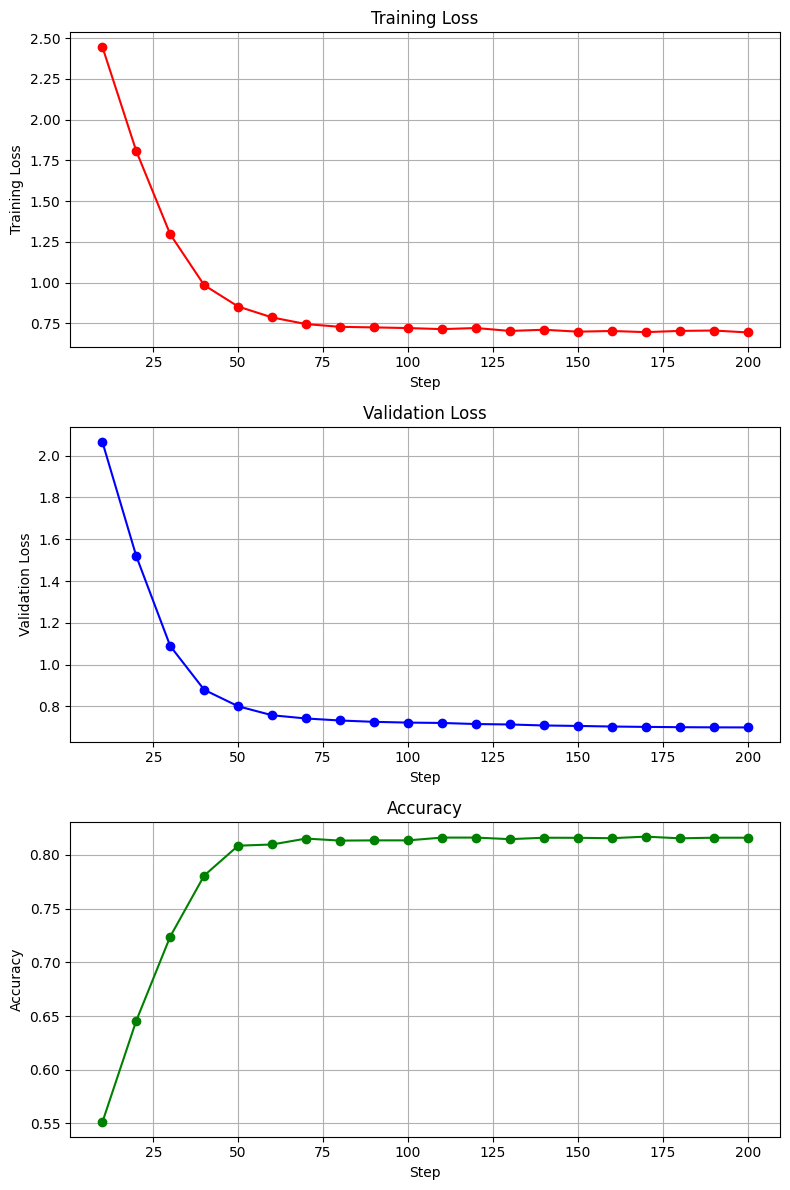

In [11]:
import matplotlib.pyplot as plt

# Ensure that 'steps' and 'training_loss' have the same length
min_length = min(len(steps), len(training_loss), len(validation_loss), len(accuracy))
steps = steps[:min_length]
training_loss = training_loss[:min_length]
validation_loss = validation_loss[:min_length]
accuracy = accuracy[:min_length]


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Training Loss
axs[0].plot(steps, training_loss, marker='o', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Training Loss')
axs[0].grid(True)

# Plot Validation Loss
axs[1].plot(steps, validation_loss, marker='o', color='blue')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Validation Loss')
axs[1].grid(True)

# Plot Accuracy
axs[2].plot(steps, accuracy, marker='o', color='green')
axs[2].set_title('Accuracy')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Accuracy')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [13]:
import colab_env
import os

access_token_write = os.getenv("HUGGINGFACE_ACCESS_TOKEN_WRITE")

from huggingface_hub import login

login(
  token=access_token_write,
  add_to_git_credential=True
)

In [20]:
#!pip install huggingface_hub --quiet
from huggingface_hub import HfApi

api = HfApi()
api.get_token_permission(token=access_token_write)
#api.set_access_token(access_token)

repo_id = 'frankmorales2020/flight_plan_waypoints_finetuned'
api.delete_repo(repo_id=repo_id)

In [21]:
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HUGGINGFACE_ACCESS_TOKEN_WRITE"))

# Create the repo if it doesn't exist
api.create_repo(
    repo_id="frankmorales2020/flight_plan_waypoints_finetuned",
    repo_type="model",
    exist_ok=True,  # Avoid error if repo already exists
)

# Now upload the folder
api.upload_folder(
    folder_path="/content/results",
    repo_id="frankmorales2020/flight_plan_waypoints_finetuned",
    repo_type="model",
)

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/27.4M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/frankmorales2020/flight_plan_waypoints_finetuned/commit/1afa4f7b94a0c24494388212b20425d6a5038c50', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1afa4f7b94a0c24494388212b20425d6a5038c50', pr_url=None, repo_url=RepoUrl('https://huggingface.co/frankmorales2020/flight_plan_waypoints_finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='frankmorales2020/flight_plan_waypoints_finetuned'), pr_revision=None, pr_num=None)